# ITU-T G.227 複素数フィルタ → 実数フィルタ

まず、ITU-T G.227 https://www.itu.int/rec/T-REC-G.227-198811-I/en

記載の伝達関数を周波数特性としてグラフ化。普通のフィルタのグラフと違ってyはゲインではなくロスなので注意


$$ \frac{E}{2V} = 
\frac{
  18400 + 91238\ p^2 + 11638\ p^4 + p (67280 + 54050\ p^2)
}{
  400 + 4001\ p^2 + p^4 + p (36040 + 130\ p^2)
}
$$
$$
p = j \frac{f}{1000}
$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import json

def g227(niq, size):
    f = np.linspace(0, niq, size)
    p = 1j * f / 1000
    numerator = 18400 + 91238*p**2 + 11638*p**4 + p*(67280 + 54050*p**2)
    denominator = 400 + 4001*p**2 + p**4 + p*(36040 + 130*p**2)
    loss = np.abs(numerator / denominator)
    dB = 20 * np.log10(loss)
    # adjust gain
    dB -= np.min(dB)
    loss = np.power(10, dB / 20)
    return f, loss

0.0


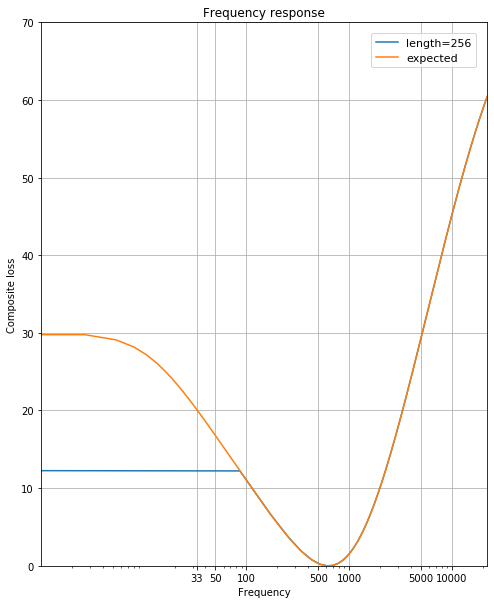

In [2]:
sr = 44100
firlen = 513
xticks = [33, 50, 100, 500, 1000, 5000, 10000]

f_m, loss_m = g227(sr/2, 2**13)
f, loss = g227(sr/2, int(firlen/2))

print(np.min(20 * np.log10(loss)))
plt.figure(figsize=(8,10))
plt.title("Frequency response")
plt.xscale('log')
plt.grid(True)
plt.ylabel('Composite loss')
plt.xlabel('Frequency')
plt.ylim((0, 70))
#plt.xlim((33, 10000))
plt.xlim((1, sr/2))
plt.xticks(xticks, xticks)
plt.plot(f, 20 * np.log10(loss), label="length=%d" % int(firlen/2))
plt.plot(f_m, 20 * np.log10(loss_m), label="expected")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)

plt.show()

# FIR

そのまま IFFT して有限インパルス応答 (FIR) を得る。フィルタにしたいのでロスの逆数をとってゲインにしている。

513


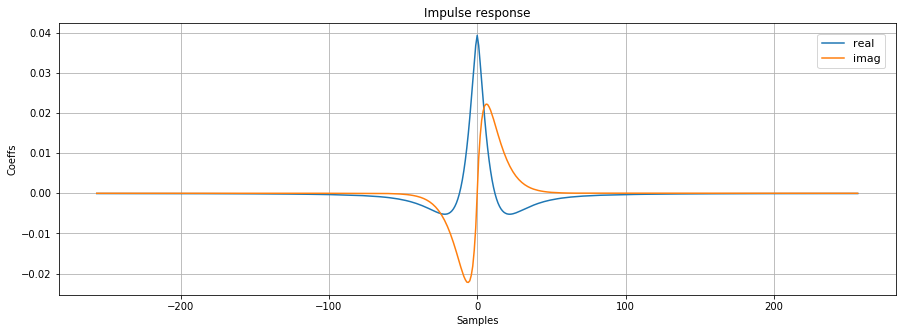

In [3]:
fir = np.fft.fftshift(np.fft.ifft(1.0/loss, n=firlen))
print(len(fir))
x = np.linspace(-firlen/2, firlen/2, len(fir))
plt.figure(figsize=(15,5))
plt.title("Impulse response")
plt.grid(True)
plt.ylabel("Coeffs")
plt.xlabel("Samples")
#plt.xlim((-30,30))
plt.plot(x, np.real(fir), label="real")
plt.plot(x, np.imag(fir), label="imag")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)
plt.show()

# FIR の周波数特性

求めた FIR の周波数特性を評価する。freqz を使う。


12.702398360824748
Max Error 61.17456417683514 dB at 22006.93359375 Hz
MSE 22.082582995621816 dB


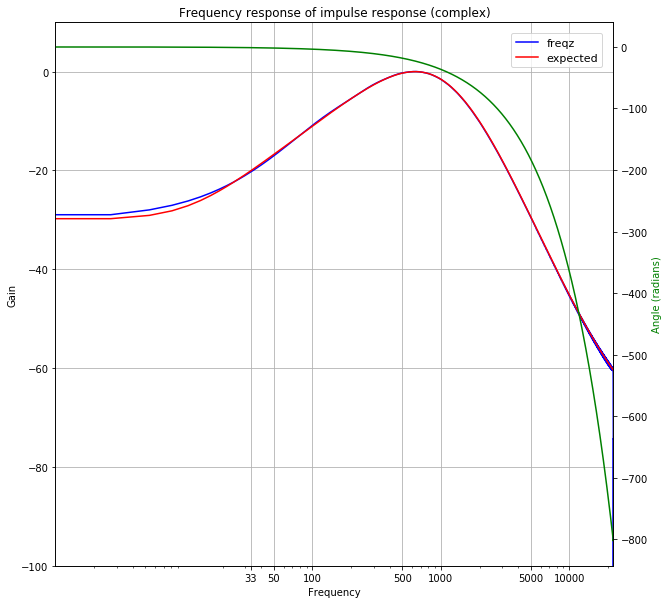

In [4]:
w, h = signal.freqz(fir, worN=2**13)
x = w * sr * 1.0 / (2 * np.pi)
plt.figure(figsize=(10,10))
plt.title("Frequency response of impulse response (complex)")
plt.xscale('log')
plt.grid(True)
plt.ylabel('Gain')
plt.xlabel('Frequency')
plt.xlim((1, sr/2))
plt.ylim((-100, 10))
plt.xticks(xticks, xticks)

freqz_dB = 20 * np.log10(abs(h))
expected_dB = -20 * np.log10(loss_m)
plt.plot(x, freqz_dB, 'b', label="freqz")
plt.plot(f_m, expected_dB, 'r', label="expected")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)
print(len(h) / np.sum(np.abs(h)))

error = np.abs(freqz_dB- expected_dB)
print('Max Error', np.max(error), 'dB', 'at', x[np.argmax(error)], 'Hz')
print('MSE',  20*np.log10(np.sqrt(np.mean(np.power(10, error / 20)**2))), 'dB')

ax2 = plt.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(x, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')

plt.show()

# 実数フィルタ

実数フィルタにする。


12.698620856044219
Max Error 57.26387170919799 dB at 22006.93359375 Hz
MSE 18.21432638645039 dB


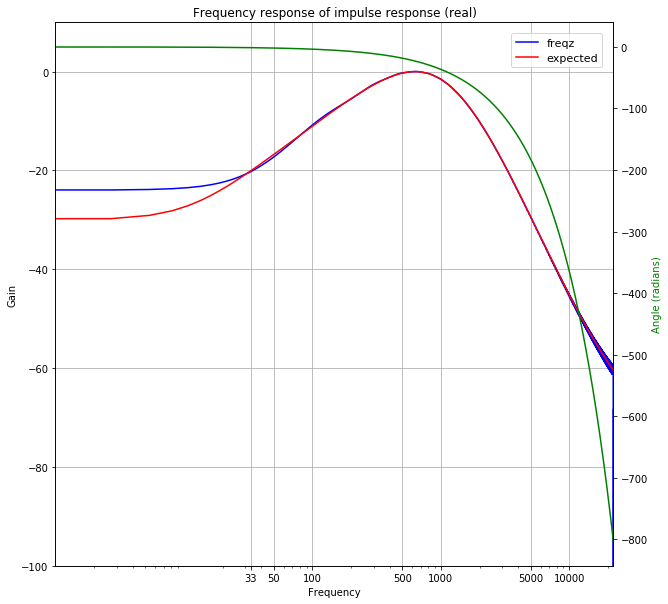

In [5]:
firr = np.copy(np.real(fir))
firr *= 2

w, h = signal.freqz(firr, worN=2**13)
x = w * sr * 1.0 / (2 * np.pi)

plt.figure(figsize=(10,10))
plt.title("Frequency response of impulse response (real)")
plt.xscale('log')
plt.grid(True)
plt.ylabel('Gain')
plt.xlabel('Frequency')
plt.xlim((1, sr/2))
plt.ylim((-100, 10))
plt.xticks(xticks, xticks)

freqz_dB = 20 * np.log10(abs(h))
expected_dB = -20 * np.log10(loss_m)
plt.plot(x, freqz_dB, 'b', label="freqz")
plt.plot(f_m, expected_dB, 'r', label="expected")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=11)
print(len(h) / np.sum(np.abs(h)))
error = np.abs(freqz_dB- expected_dB)
print('Max Error', np.max(error), 'dB', 'at', x[np.argmax(error)], 'Hz')
print('MSE',  20*np.log10(np.sqrt(np.mean(np.power(10, error / 20)**2))), 'dB')

ax2 = plt.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(x, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
plt.show()

# JSON

In [6]:
print(json.dumps(list(map(lambda x: (x.real, x.imag), fir))))

[[-6.180171231999265e-05, -9.363064745945171e-07], [-6.178820397942836e-05, 8.880029113502316e-07], [-6.185158905688193e-05, -9.8419608839212e-07], [-6.181107878306835e-05, 8.392852645665589e-07], [-6.193786502482514e-05, -1.0316718249994602e-06], [-6.187039709126612e-05, 7.901533382799915e-07], [-6.206061673305784e-05, -1.0787336947006548e-06], [-6.196626502863231e-05, 7.40606874390972e-07], [-6.221996657939379e-05, -1.1253816454658483e-06], [-6.209883475840911e-05, 6.906455522378203e-07], [-6.241608318749344e-05, -1.171615562409222e-06], [-6.22683048807548e-05, 6.402689879459387e-07], [-6.26491818688762e-05, -1.2174352670603478e-06], [-6.247492095676518e-05, 5.894767335920336e-07], [-6.291952521182611e-05, -1.2628405164233077e-06], [-6.271897616073131e-05, 5.382682761598997e-07], [-6.322742379999499e-05, -1.3078310018369405e-06], [-6.300081206363113e-05, 4.866430362898774e-07], [-6.35732370640168e-05, -1.3524063476253306e-06], [-6.332081955164627e-05, 4.3460036681814107e-07], [-6.395

In [7]:
print(json.dumps(list(map(lambda x: x.real, firr))))

[-0.0001236034246399853, -0.00012357640795885672, -0.00012370317811376385, -0.0001236221575661367, -0.00012387573004965028, -0.00012374079418253224, -0.00012412123346611568, -0.00012393253005726462, -0.00012443993315878758, -0.00012419766951681822, -0.00012483216637498688, -0.0001245366097615096, -0.0001252983637377524, -0.00012494984191353036, -0.00012583905042365222, -0.00012543795232146263, -0.00012645484759998997, -0.00012600162412726226, -0.0001271464741280336, -0.00012664163910329254, -0.00012791474854047193, -0.00012735887976799215, -0.00012876059130241977, -0.00012815433179038562, -0.0001296850273668322, -0.0001290290866949733, -0.00013068918903672868, -0.00012998434488018952, -0.00013177431914812758, -0.00013102141896516637, -0.00013294177458936804, -0.00013214173748140692, -0.0001341930301743194, -0.00013334684892778027, -0.00013552968288891868, -0.00013463842620940603, -0.00013695345653266176, -0.0001360182714830373, -0.00013846620677884092, -0.00013748832143412352, -0.00014